<h1 style='background-color:red; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 15px 50px;' > Coronavirus Disease 2019 (COVID-19) </h1>


Coronavirus disease 2019 (COVID-19) is defined as illness caused by a novel coronavirus now called severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2; formerly called 2019-nCoV), which was first identified amid an outbreak of respiratory illness cases in Wuhan City, Hubei Province, China.  It was initially reported to the WHO on December 31, 2019. On January 30, 2020, the WHO declared the COVID-19 outbreak a global health emergency.  On March 11, 2020, the WHO declared COVID-19 a global pandemic, its first such designation since declaring H1N1 influenza a pandemic in 2009.






   <img src="https://www.pharmaceutical-technology.com/wp-content/uploads/sites/10/2020/04/Malaysia_559007341-e1599478831476.jpg" width="800px">







<h1 style='background-color:red; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 15px 50px;' > What is ResNet 50 model? </h1>

ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database . The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals,
ResNet is the short name for residual Network.


<img src="https://i.ytimg.com/vi/mGMpHyiN5lk/maxresdefault.jpg" width="800px">



## Dataset in this link: 

[Here](https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


In [2]:
disease_types=['COVID', 'non-COVID']
data_dir = '../input/sarscov2-ctscan-dataset'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (230).png,0,COVID
1,COVID/Covid (1195).png,0,COVID
2,COVID/Covid (182).png,0,COVID
3,COVID/Covid (817).png,0,COVID
4,COVID/Covid (631).png,0,COVID


In [4]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (54).png,0,COVID
1,COVID/Covid (1035).png,0,COVID
2,non-COVID/Non-Covid (21).png,1,non-COVID
3,non-COVID/Non-Covid (248).png,1,non-COVID
4,COVID/Covid (409).png,0,COVID


In [5]:
import pandas_profiling as pp
pp.ProfileReport(train)

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


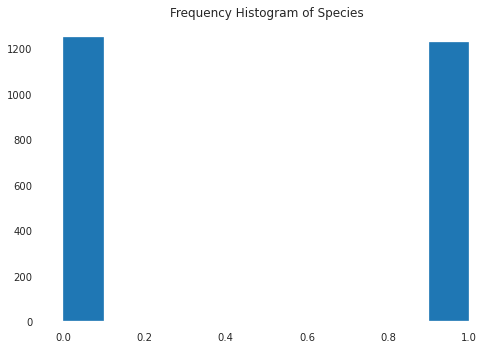

<Figure size 864x864 with 0 Axes>

In [6]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

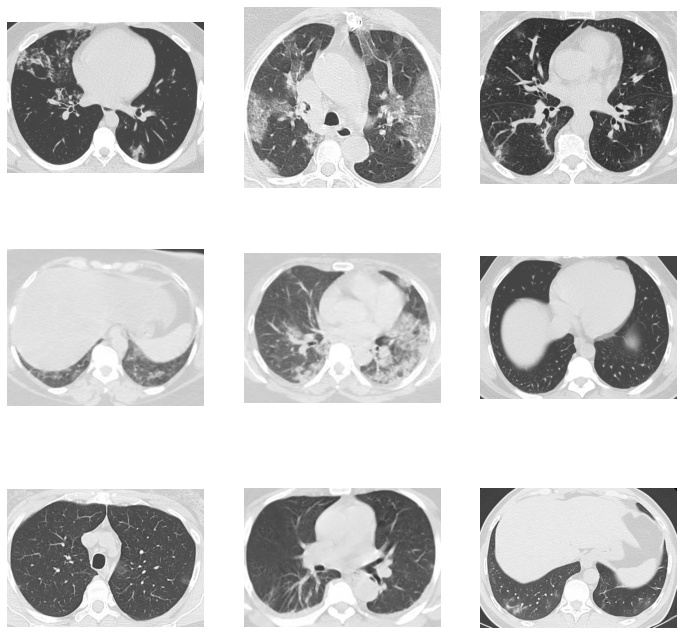

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 3, 3)

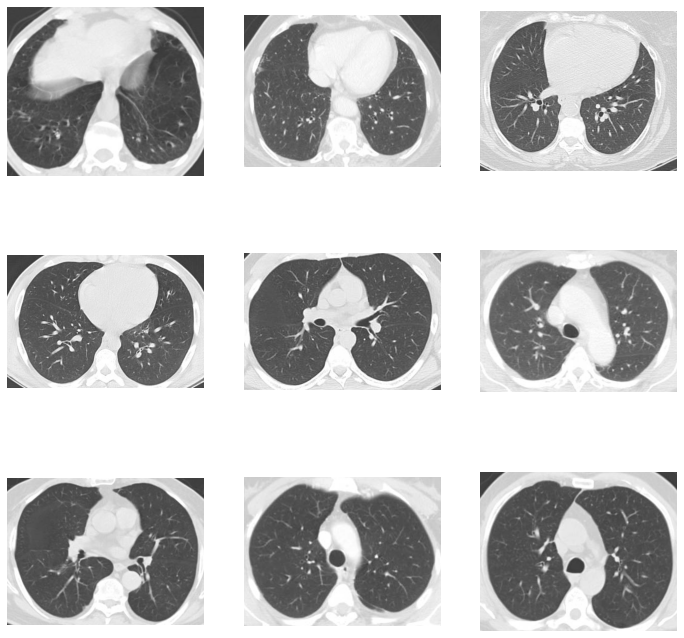

In [8]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 3, 3)

In [9]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [10]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:41, 60.46it/s]


Train Shape: (2481, 64, 64, 3)


In [11]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2481, 2)


In [12]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)


In [13]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1984, 64, 64, 3)
X_val: (497, 64, 64, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


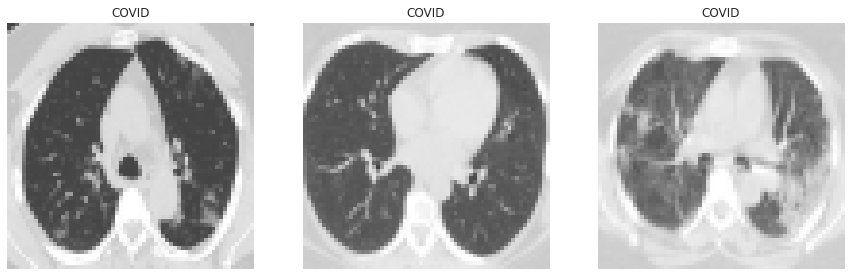

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [15]:
EPOCHS = 50
SIZE=64
N_ch=3

In [16]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [17]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)


94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_______________________________________________________

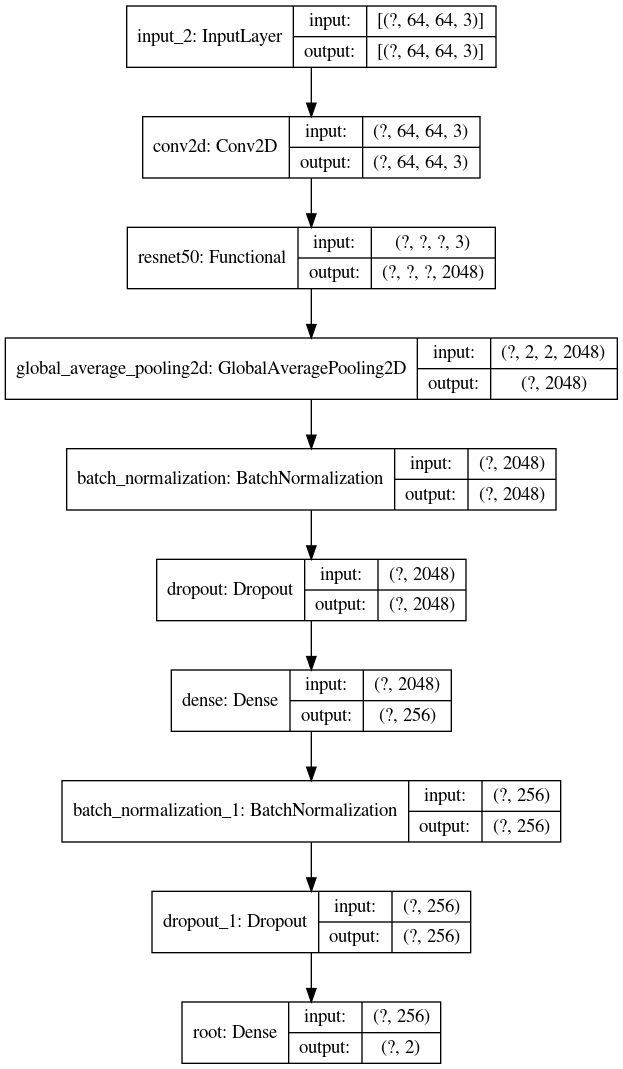

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [19]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.1945 - accuracy: 0.5232
Epoch 00001: val_loss improved from inf to 0.67954, saving model to model.h5
31/31 [==============================] - 128s 4s/step - loss: 1.1945 - accuracy: 0.5232 - val_loss: 0.6795 - val_accuracy: 0.5513
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.9355 - accuracy: 0.6043
Epoch 00002: val_loss did not improve from 0.67954
31/31 [==============================] - 126s 4s/step - loss: 0.9355 - accuracy: 0.6043 - val_loss: 3.8568 - val_accuracy: 0.5513
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.8596 - accuracy: 0.6462
Epoch 00003: val_loss did not improve from 0.67954
31/31 [==============================] - 123s 4s/step - loss: 0.8596 - accuracy: 0.6462 - val_loss: 4.0894 - val_accuracy: 0.5513
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.6638
Epoch 00004: val_loss did not improve from 0.67954
31/3

In [20]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 3s 200ms/step - loss: 0.2453 - accuracy: 0.8954
Final Loss: 0.24530841410160065, Final Accuracy: 0.895372211933136


Text(0.5, 141.81999999999996, 'Predicted')

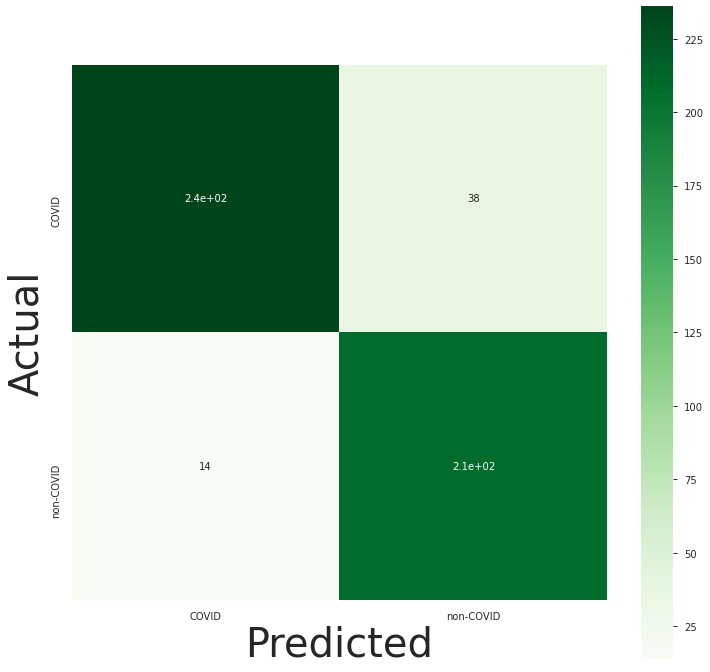

In [21]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

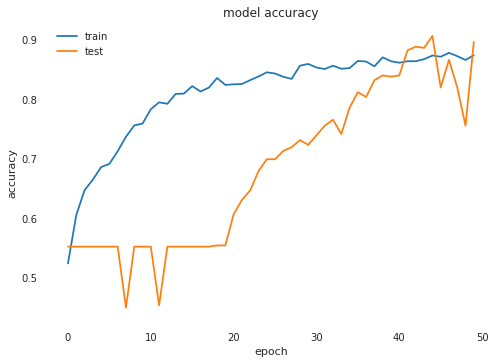

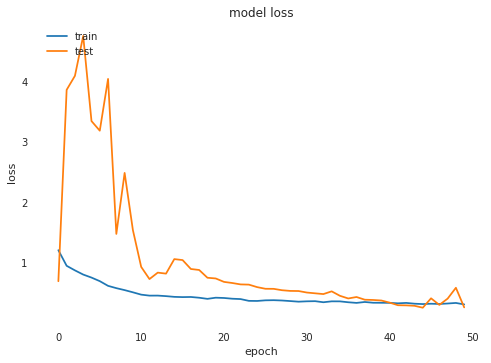

In [22]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[0.99746287 0.00253709]


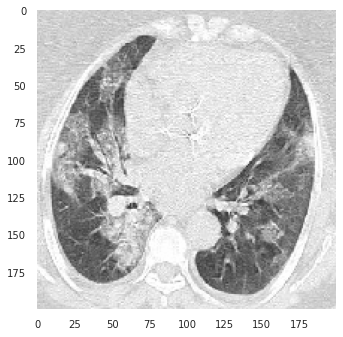

Prediction: Covid-19


In [23]:
from skimage import io
from keras.preprocessing import image
img = image.load_img('../input/sarscov2-ctscan-dataset/COVID/Covid (1014).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('../input/sarscov2-ctscan-dataset/COVID/Covid (1014).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])